In [1]:
import torch
from torch.amp import GradScaler, autocast
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils import resample
import pandas as pd
import numpy as np
import evaluate

In [2]:
from transformers import AutoTokenizer, get_scheduler, AutoModelForSequenceClassification

models = ['distilbert', 'bertimbau', 'albertina']  # 'bertimbau', 'distilbert', 'albertina'
train_size = 100000 # Terá 50% de cada label
batch_size = 4 # tamanho do batch pro treino (32 funciona pro bert, pra roBerTa é menos, isso tem a ver com a VRAM necessária)
max_length = 256 # tamanho máximo das sequencias de entrada pro modelo, se a entrada for maior, ele trunca.
num_workers = 8 # quantidade de workers (maior mais memoria gasta mais rapido o treino)

In [3]:
def evaluateModel(model, data_loader, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            logits = outputs.logits
            if logits.shape[1] == 1:
                predictions = (logits > 0).long().squeeze(1)
            else:
                predictions = torch.argmax(logits, dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    eval_pred = (np.array(all_predictions), np.array(all_labels))
    metrics = compute_metrics(eval_pred)
    return total_loss / len(data_loader), metrics

In [4]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [5]:
def compute_metrics(predictions, labels):
    predictions = np.array(predictions)
    labels = np.array(labels)

    predictions = np.argmax(predictions, axis=1) if predictions.ndim > 1 else predictions

    f1_score = f1.compute(predictions=predictions, references=labels, average="weighted")
    precision_score = precision.compute(predictions=predictions, references=labels, average="weighted")
    recall_score = recall.compute(predictions=predictions, references=labels, average="weighted")
    accuracy_score = accuracy.compute(predictions=predictions, references=labels)

    return {
        'f1': f1_score['f1'],
        'precision': precision_score['precision'],
        'recall': recall_score['recall'],
        'accuracy': accuracy_score['accuracy'],
    }

def save_confusion_matrix(labels, predictions, model_name):
    cm = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Didn't like", "Liked"])
    
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.savefig(f'confusion_matrix_{model_name}.png', dpi=300)

Evaluating distilbert: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:33<00:00, 53.34it/s]


Métricas para o modelo distilbert: {'f1': 0.8954977322388797, 'precision': 0.895512677503232, 'recall': 0.8955, 'accuracy': 0.8955}


Evaluating bertimbau: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:49<00:00, 29.42it/s]


Métricas para o modelo bertimbau: {'f1': 0.9048998364249755, 'precision': 0.90489996242317, 'recall': 0.9049, 'accuracy': 0.9049}


Evaluating albertina: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:24<00:00, 18.91it/s]


Métricas para o modelo albertina: {'f1': 0.9001482667792654, 'precision': 0.9001591770907489, 'recall': 0.90015, 'accuracy': 0.90015}


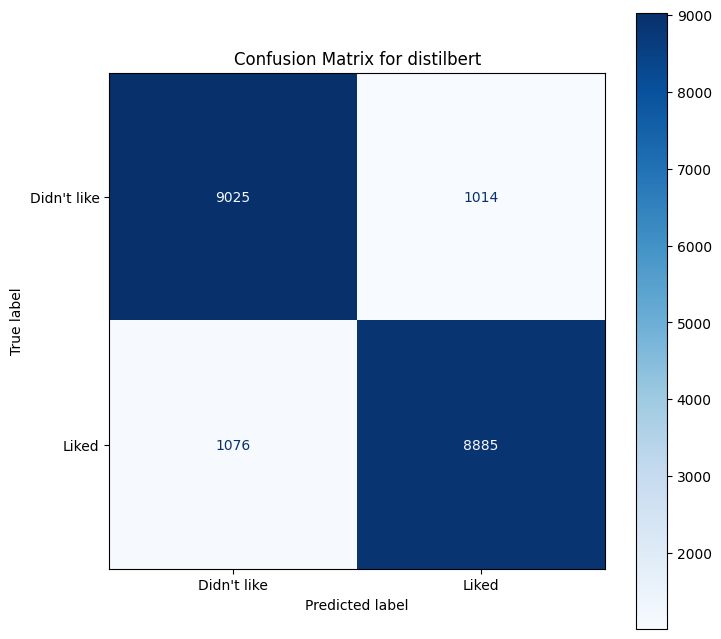

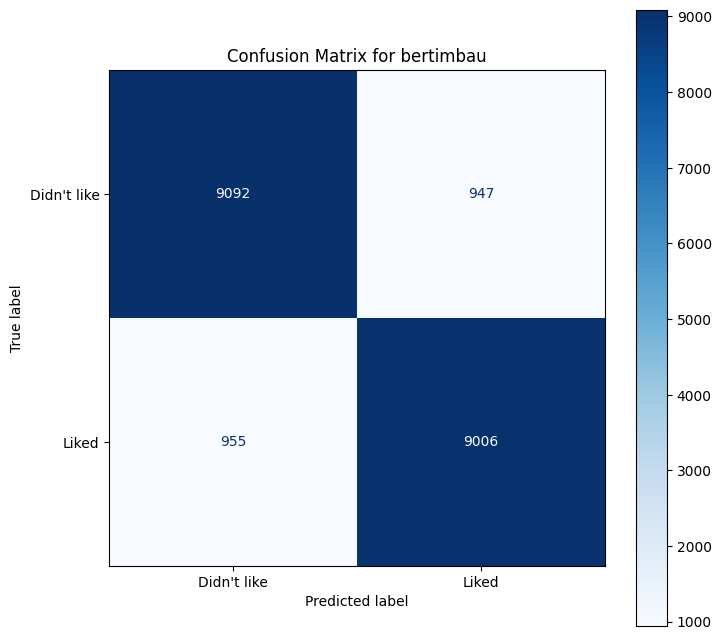

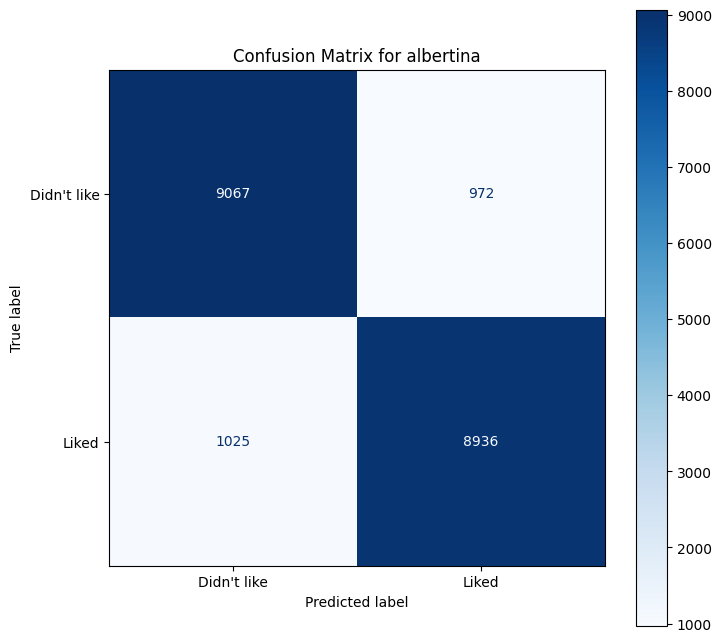

In [6]:
accuracy = evaluate.load("accuracy")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")

df = pd.read_parquet('../reviews/reviews_cleaned.parquet')

num_samples = min(train_size, df['label'].value_counts().min())
undersampled_dfs = []

for label in df['label'].unique():
    df_label = df[df['label'] == label]
    if len(df_label) > num_samples:
        df_label = resample(df_label, 
                            replace=False, 
                            n_samples=num_samples, 
                            random_state=42)
    undersampled_dfs.append(df_label)

df = pd.concat(undersampled_dfs)

train_df, val_df = train_test_split(df, test_size=0.10, random_state=42)

all_metrics = []

for model_choice in models:
    if model_choice == 'bertimbau':
        model_save_path = '../models/bert_model_15-08-2024-16-06_200000'
        tokenizer_save_path = '../models/bert_tokenizer_15-08-2024-16-06_200000'
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_save_path, clean_up_tokenization_spaces=True)
        model = AutoModelForSequenceClassification.from_pretrained(model_save_path)
    elif model_choice == 'albertina':
        model_save_path = '../models/albertina-ptbr_model_15-08-2024-11-19_200000'
        tokenizer_save_path = '../models/albertina-ptbr_tokenizer_15-08-2024-11-19_200000'
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_save_path, clean_up_tokenization_spaces=True)
        model = AutoModelForSequenceClassification.from_pretrained(model_save_path)
    elif model_choice == 'distilbert':
        model_save_path = '../models/distilbert_model_15-08-2024-14-57_200000'
        tokenizer_save_path = '../models/distilbert_tokenizer_15-08-2024-14-57_200000'
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_save_path, clean_up_tokenization_spaces=True)
        model = AutoModelForSequenceClassification.from_pretrained(model_save_path)
    else:
        raise ValueError("Modelo desconhecido! Escolha entre 'bert', 'distilbert', ou 'albertina'.")
        
    val_dataset = SentimentDataset(val_df['text'].tolist(), val_df['label'].tolist(), tokenizer, max_length=max_length)

    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Evaluating {model_choice}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
    
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
    
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    metrics = compute_metrics(all_preds, all_labels)
    print(f"Métricas para o modelo {model_choice}: {metrics}")
    all_metrics.append(metrics)
    save_confusion_matrix(all_labels, all_preds, model_choice)
    

